# Car Prediction

In [1]:
!pip install -q efficientnet

     |████████████████████████████████| 50 kB 6.3 MB/s 


In [2]:
import os, re, math, random, time, gc, string, pickle, shutil, pathlib, itertools
import numpy as np, pandas as pd, matplotlib.pyplot as plt, PIL

import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.xception import Xception
from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
import os, re, math, random, time, gc, string, pickle, shutil, pathlib, itertools


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB2
from tensorflow.keras.layers import *
from tensorflow import keras
import efficientnet.tfkeras as efn

import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

#print(os.listdir("../input/sf-dl-car-classification"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.7.13 (default, Mar 16 2022, 17:37:17) 
Numpy        : 1.21.6
Tensorflow   : 2.8.0
Keras        : 2.8.0


In [4]:
#имена классов
class_names = [
  'Приора', #0
  'Ford Focus', #1
  'Самара', #2
  'ВАЗ-2110', #3
  'Жигули', #4
  'Нива', #5
  'Калина', #6
  'ВАЗ-2109', #7
  'Volkswagen Passat', #8
  'ВАЗ-21099' #9
]

In [34]:
EPOCHS               = 10
BATCH_SIZE           = 64
LR                   = 1e-4
VAL_SPLIT            = 0.2

CLASS_NUM            = 10
IMG_SIZE             = 200 
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
RANDOM_SEED          = 42

# Upload

In [6]:
!gsutil cp gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip .
!unzip sf-dl-car-classification.zip
!unzip -q -o sf-dl-car-classification/train.zip
!unzip -q -o sf-dl-car-classification/test.zip
sample_submission_path = '/content/sf-dl-car-classification/sample-submission.csv'
train_path = '/content/train/'
sub_path = '/content/test_upload/'

Copying gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip...
| [1 files][  1.6 GiB/  1.6 GiB]   66.0 MiB/s                                   
Operation completed over 1 objects/1.6 GiB.                                      
Archive:  sf-dl-car-classification.zip
   creating: sf-dl-car-classification/
  inflating: sf-dl-car-classification/sample-submission.csv  
  inflating: sf-dl-car-classification/train.csv  
 extracting: sf-dl-car-classification/test.zip  
 extracting: sf-dl-car-classification/train.zip  


# Data Generation + Augmentation

In [35]:
!pip install --upgrade albumentations
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor -q

In [36]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.CoarseDropout(p=1, max_height=18, max_width=18), 
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),

    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5)
])
train_datagen = ImageDataAugmentor(
        augment = AUGMENTATIONS,
        validation_split=0.2,
        )
val_datagen = ImageDataGenerator(
    validation_split=0.2,
    )
sub_datagen = ImageDataGenerator()

In [37]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=[IMG_SIZE, IMG_SIZE],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=[IMG_SIZE, IMG_SIZE],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='validation'
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=[IMG_SIZE, IMG_SIZE],
    batch_size=BATCH_SIZE,
    shuffle=False
)

/usr/local/lib/python3.7/dist-packages/ImageDataAugmentor/image_data_augmentor.py:333: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Train:


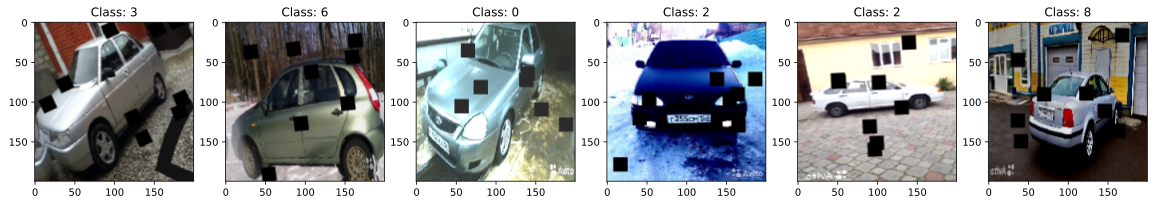

Val:


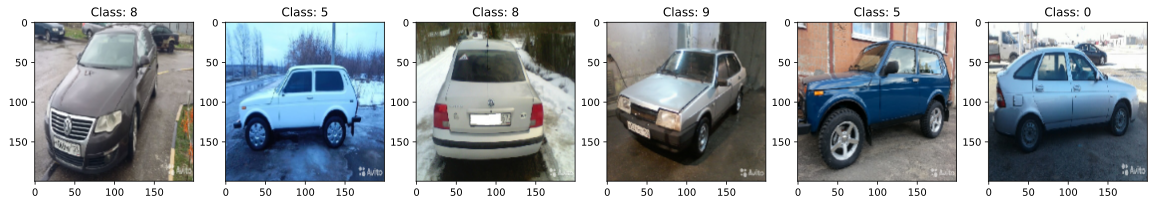

In [38]:
def show_first_images(generator, count=6, labels=True, figsize=(20, 5), normalized=False):
  generator = itertools.islice(generator, count)
  fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
  for batch, ax in zip(generator, axes):
    if labels:
      img_batch, labels_batch = batch
      img, label = img_batch[0], np.argmax(labels_batch[0]) #берем по одному изображению из каждого батча
    else:
      img_batch = batch
      img = img_batch[0]
    if not normalized:
      img = img.astype(np.uint8)
    ax.imshow(img)
    # метод imshow принимает одно из двух:
    # - изображение в формате uint8, яркость от 0 до 255
    # - изображение в формате float, яркость от 0 до 1
    if labels:
      ax.set_title(f'Class: {label}')
  plt.show()

print('Train:')
show_first_images(train_generator)

print('Val:')
show_first_images(val_generator)

# Xception

# EfficientnetB2

In [39]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
callbacks = [checkpoint, earlystop]

In [40]:
# строим модель
model = Sequential([
  EfficientNetB2(weights='imagenet', input_shape=input_shape, include_top=False), #предобученная нейросеть из модуля keras.applications
  GlobalMaxPool2D(),
  Dense(256, activation='relu'),
  BatchNormalization(),
  Dropout(0.5),
  Dense(10, activation='softmax')
])

model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(ExponentialDecay(1e-3, decay_steps = BATCH_SIZE*3, decay_rate=0.9)),
    metrics='accuracy'
)

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 global_max_pooling2d_2 (Glo  (None, 1408)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               360704    
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 10)               

In [42]:
EPOCHS = 10

In [43]:
history = model.fit(train_generator, 
          steps_per_epoch = len(train_generator),
          validation_data=val_generator, 
          validation_steps = len(val_generator),
          epochs=EPOCHS,
          callbacks=callbacks)

Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 1.2207 - accuracy: 0.5962
Epoch 1: saving model to best_model.hdf5
195/195 [==============================] - 185s 833ms/step - loss: 1.2207 - accuracy: 0.5962 - val_loss: 0.4280 - val_accuracy: 0.8556
Epoch 2/10
195/195 [==============================] - ETA: 0s - loss: 0.4007 - accuracy: 0.8587
Epoch 2: saving model to best_model.hdf5
195/195 [==============================] - 160s 819ms/step - loss: 0.4007 - accuracy: 0.8587 - val_loss: 0.2516 - val_accuracy: 0.9119
Epoch 3/10
195/195 [==============================] - ETA: 0s - loss: 0.2765 - accuracy: 0.9046
Epoch 3: saving model to best_model.hdf5
195/195 [==============================] - 161s 826ms/step - loss: 0.2765 - accuracy: 0.9046 - val_loss: 0.2032 - val_accuracy: 0.9286
Epoch 4/10
195/195 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.9280
Epoch 4: saving model to best_model.hdf5
195/195 [==============================] - 161s

In [44]:
model.save('model_effnet.hdf5')
model.load_weights('best_model.hdf5')

In [46]:
scores = model.evaluate_generator(val_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


1/1 [==============================] - 1s 922ms/step - loss: 0.2265 - accuracy: 0.9375
Accuracy: 93.75%


In [47]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


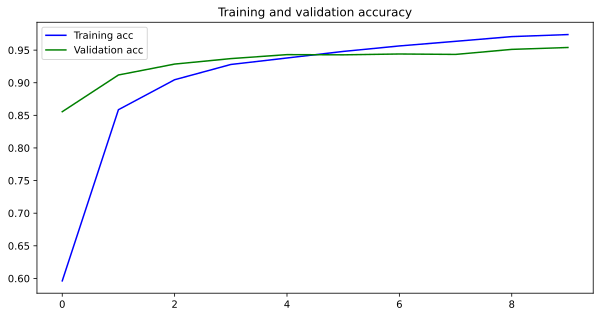

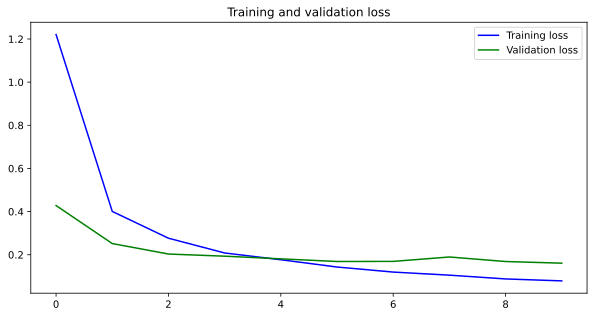

In [52]:
plot_history(history)

In [50]:
sub_generator.reset()
predictions = model.predict_generator(sub_generator, steps=len(sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


105/105 [==============================] - 48s 427ms/step


In [51]:
submission = pd.DataFrame({'Id':sub_generator.filenames, 'Category':predictions}, columns=['Id', 'Category'])
submission.to_csv('submission_effnetB2.csv', index=False)

# Fine Tuning

## Step 1

In [83]:
EPOCHS               = 15
BATCH_SIZE           = 32
LR                   = 1e-4
VAL_SPLIT            = 0.2

CLASS_NUM            = 10
IMG_SIZE             = 250 
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
RANDOM_SEED          = 42

In [84]:
base_model = efn.EfficientNetB2(weights='imagenet', include_top=False, input_shape=input_shape)

In [92]:
base_model.trainable = False

In [87]:
LR = ExponentialDecay(1e-3, decay_steps = BATCH_SIZE*3, decay_rate=0.9)

In [88]:
model = Sequential([
  base_model,
  GlobalMaxPool2D(),
  Dense(256, activation='relu'),
  BatchNormalization(),
  Dropout(0.5),
  Dense(10, activation='softmax')
])

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [91]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b2 (Functional  (None, 8, 8, 1408)       7768562   
 )                                                               
                                                                 
 global_max_pooling2d_4 (Glo  (None, 1408)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_8 (Dense)             (None, 256)               360704    
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                      

In [98]:
for layer in model.layers:
  print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x7f687ce83950> False
<keras.layers.pooling.GlobalMaxPooling2D object at 0x7f687cd2e8d0> True
<keras.layers.core.dense.Dense object at 0x7f687cd2e110> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f687ccf6350> True
<keras.layers.core.dropout.Dropout object at 0x7f687ce7cf90> True
<keras.layers.core.dense.Dense object at 0x7f687cd6a1d0> True


In [102]:
scores = model.evaluate_generator(val_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


1/1 [==============================] - 4s 4s/step - loss: 6425.5469 - accuracy: 0.0938
Accuracy: 9.38%


In [103]:
history = model.fit(train_generator, 
          steps_per_epoch = len(train_generator),
          validation_data=val_generator, 
          validation_steps = len(val_generator),
          epochs=EPOCHS,
          callbacks=callbacks)

Epoch 1/15
195/195 [==============================] - ETA: 0s - loss: 2.9177 - accuracy: 0.1030
Epoch 1: saving model to best_model.hdf5
195/195 [==============================] - 102s 482ms/step - loss: 2.9177 - accuracy: 0.1030 - val_loss: 2.3239 - val_accuracy: 0.1187
Epoch 2/15
195/195 [==============================] - ETA: 0s - loss: 2.6586 - accuracy: 0.1068
Epoch 2: saving model to best_model.hdf5
195/195 [==============================] - 100s 514ms/step - loss: 2.6586 - accuracy: 0.1068 - val_loss: 2.3165 - val_accuracy: 0.1171
Epoch 3/15
195/195 [==============================] - ETA: 0s - loss: 2.5669 - accuracy: 0.1023
Epoch 3: saving model to best_model.hdf5
195/195 [==============================] - 98s 503ms/step - loss: 2.5669 - accuracy: 0.1023 - val_loss: 2.3027 - val_accuracy: 0.1213
Epoch 4/15
195/195 [==============================] - ETA: 0s - loss: 2.4942 - accuracy: 0.1120
Epoch 4: saving model to best_model.hdf5
195/195 [==============================] - 89s 4

In [104]:
model.save('model_effnet_step1.hdf5')
model.load_weights('best_model.hdf5')

scores = model.evaluate_generator(val_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


1/1 [==============================] - 1s 508ms/step - loss: 2.3066 - accuracy: 0.0312
Accuracy: 3.12%


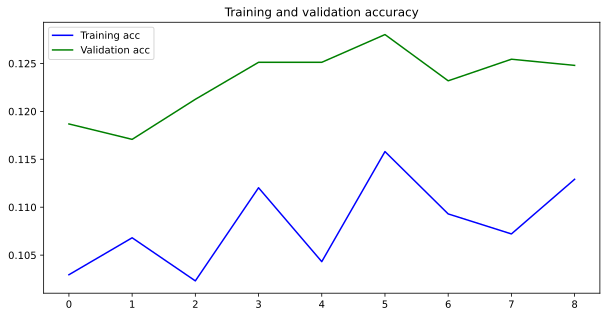

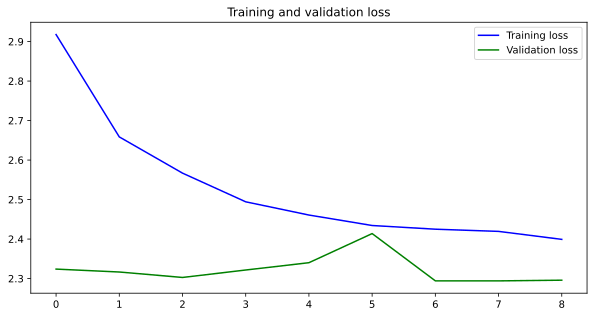

In [105]:
plot_history(history)

## Step 2

In [106]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = int(len(base_model.layers)/2)

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [107]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x7f687ce83950> True
<keras.layers.pooling.GlobalMaxPooling2D object at 0x7f687cd2e8d0> True
<keras.layers.core.dense.Dense object at 0x7f687cd2e110> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f687ccf6350> True
<keras.layers.core.dropout.Dropout object at 0x7f687ce7cf90> True
<keras.layers.core.dense.Dense object at 0x7f687cd6a1d0> True


In [108]:
BATCH_SIZE = 20
EPOCHS = 15

In [109]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [110]:
scores = model.evaluate_generator(val_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


1/1 [==============================] - 3s 3s/step - loss: 2.2794 - accuracy: 0.1406
Accuracy: 14.06%


In [111]:
history = model.fit(train_generator, 
          steps_per_epoch = len(train_generator),
          validation_data=val_generator, 
          validation_steps = len(val_generator),
          epochs=EPOCHS,
          callbacks=callbacks)

Epoch 1/15
195/195 [==============================] - ETA: 0s - loss: 2.3859 - accuracy: 0.1152
Epoch 1: saving model to best_model.hdf5
195/195 [==============================] - 109s 510ms/step - loss: 2.3859 - accuracy: 0.1152 - val_loss: 2.2929 - val_accuracy: 0.1267
Epoch 2/15
195/195 [==============================] - ETA: 0s - loss: 2.3500 - accuracy: 0.1232
Epoch 2: saving model to best_model.hdf5
195/195 [==============================] - 98s 501ms/step - loss: 2.3500 - accuracy: 0.1232 - val_loss: 2.2912 - val_accuracy: 0.1267
Epoch 3/15
195/195 [==============================] - ETA: 0s - loss: 2.3232 - accuracy: 0.1303
Epoch 3: saving model to best_model.hdf5
195/195 [==============================] - 98s 500ms/step - loss: 2.3232 - accuracy: 0.1303 - val_loss: 2.2876 - val_accuracy: 0.1267
Epoch 4/15
195/195 [==============================] - ETA: 0s - loss: 2.2947 - accuracy: 0.1441
Epoch 4: saving model to best_model.hdf5
195/195 [==============================] - 99s 50

In [112]:
model.save('model_effnet_step2.hdf5')
model.load_weights('best_model.hdf5')

scores = model.evaluate_generator(val_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 486ms/step - loss: 2.2983 - accuracy: 0.1406
Accuracy: 14.06%


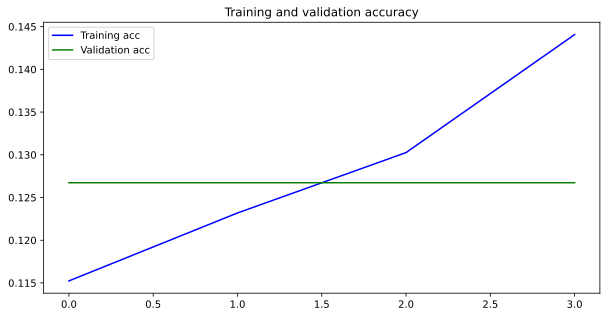

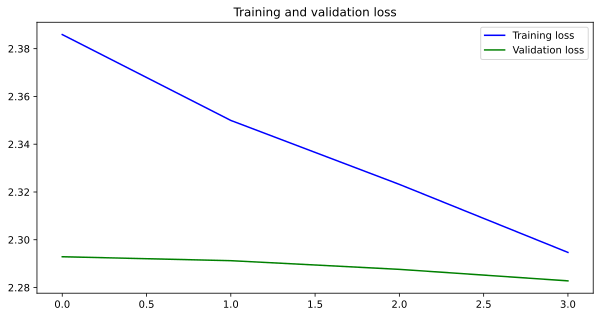

In [113]:
plot_history(history)

## Step 3

In [114]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks = [checkpoint, earlystop]

In [116]:
BATCH_SIZE = 32
EPOCHS = 15

Not changing anything because EarlyStopping was made too short

In [119]:
# Check the trainable status of the individual layers
len(base_model.trainable_variables)


149

In [120]:
history = model.fit(train_generator, 
          steps_per_epoch = len(train_generator),
          validation_data=val_generator, 
          validation_steps = len(val_generator),
          epochs=EPOCHS,
          callbacks=callbacks)

Epoch 1/15
195/195 [==============================] - ETA: 0s - loss: 2.2792 - accuracy: 0.1460
Epoch 1: saving model to best_model.hdf5
195/195 [==============================] - 104s 533ms/step - loss: 2.2792 - accuracy: 0.1460 - val_loss: 2.2752 - val_accuracy: 0.1267
Epoch 2/15
195/195 [==============================] - ETA: 0s - loss: 2.2429 - accuracy: 0.1676
Epoch 2: saving model to best_model.hdf5
195/195 [==============================] - 101s 517ms/step - loss: 2.2429 - accuracy: 0.1676 - val_loss: 2.2438 - val_accuracy: 0.1560
Epoch 3/15
195/195 [==============================] - ETA: 0s - loss: 2.1929 - accuracy: 0.1871
Epoch 3: saving model to best_model.hdf5
195/195 [==============================] - 101s 517ms/step - loss: 2.1929 - accuracy: 0.1871 - val_loss: 2.1469 - val_accuracy: 0.2345
Epoch 4/15
195/195 [==============================] - ETA: 0s - loss: 2.1486 - accuracy: 0.2037
Epoch 4: saving model to best_model.hdf5
195/195 [==============================] - 100s

In [121]:
model.save('model_effnet_step2.hdf5')
model.load_weights('best_model.hdf5')

scores = model.evaluate_generator(val_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


1/1 [==============================] - 1s 522ms/step - loss: 1.5285 - accuracy: 0.4844
Accuracy: 48.44%


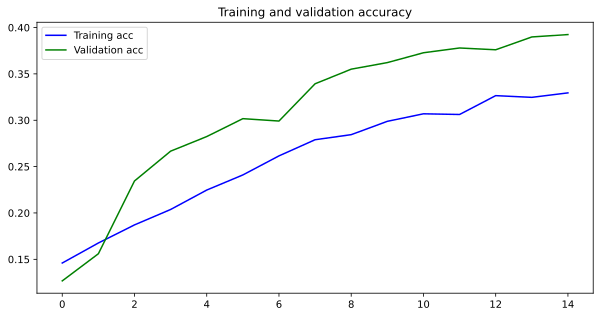

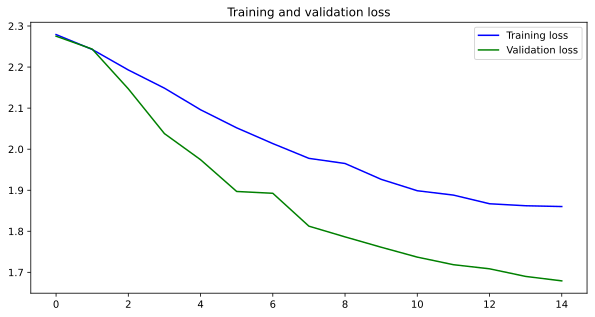

In [122]:
plot_history(history)

## Step 4

In [123]:
base_model.trainable = True

In [124]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [125]:
scores = model.evaluate_generator(val_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


1/1 [==============================] - 4s 4s/step - loss: 1.6007 - accuracy: 0.4062
Accuracy: 40.62%


In [126]:
history = model.fit(train_generator, 
          steps_per_epoch = len(train_generator),
          validation_data=val_generator, 
          validation_steps = len(val_generator),
          epochs=EPOCHS,
          callbacks=callbacks)

Epoch 1/15
195/195 [==============================] - ETA: 0s - loss: 0.9241 - accuracy: 0.6636
Epoch 1: saving model to best_model.hdf5
195/195 [==============================] - 166s 790ms/step - loss: 0.9241 - accuracy: 0.6636 - val_loss: 2.4357 - val_accuracy: 0.0936
Epoch 2/15
195/195 [==============================] - ETA: 0s - loss: 0.4149 - accuracy: 0.8458
Epoch 2: saving model to best_model.hdf5
195/195 [==============================] - 157s 806ms/step - loss: 0.4149 - accuracy: 0.8458 - val_loss: 2.4273 - val_accuracy: 0.0936
Epoch 3/15
195/195 [==============================] - ETA: 0s - loss: 0.2822 - accuracy: 0.8961
Epoch 3: saving model to best_model.hdf5
195/195 [==============================] - 159s 813ms/step - loss: 0.2822 - accuracy: 0.8961 - val_loss: 2.4853 - val_accuracy: 0.0936
Epoch 4/15
195/195 [==============================] - ETA: 0s - loss: 0.2191 - accuracy: 0.9215
Epoch 4: saving model to best_model.hdf5
195/195 [==============================] - 159s

In [128]:
model.save('model_effnet_final.hdf5')
model.load_weights('best_model.hdf5')

scores = model.evaluate_generator(val_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 492ms/step - loss: 0.0230 - accuracy: 1.0000
Accuracy: 100.00%


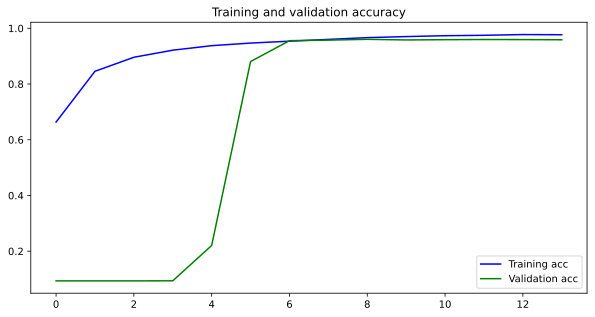

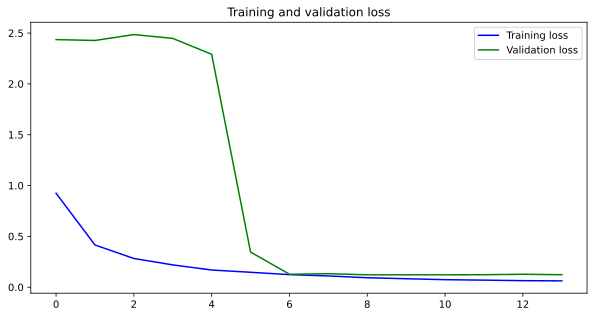

In [129]:
plot_history(history)

In [130]:
sub_generator.reset()
predictions = model.predict_generator(sub_generator, steps=len(sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


105/105 [==============================] - 47s 431ms/step


In [131]:
submission = pd.DataFrame({'Id':sub_generator.filenames, 'Category':predictions}, columns=['Id', 'Category'])
submission.to_csv('submission_effnetB2_finetuned.csv', index=False)

# Test-time Augmentations

In [133]:
predictions = []
for _ in range(5):
  predictions.append(model.predict(sub_generator, verbose=1))
  sub_generator.reset()
predictions = np.array(predictions)
predictions.shape

105/105 [==============================] - 34s 328ms/step


(5, 6675, 10)

In [135]:
final_predictions = predictions.mean(axis=0).argmax(axis=-1)

# и сохраним
submission = pd.DataFrame({
    'Id': sub_generator.filenames,
    'Category': final_predictions
}, columns=['Id', 'Category'])


submission.to_csv('submission.csv', index=False)